# По мотивам семинара:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import string
import re
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline 

morph = MorphAnalyzer()

In [3]:
train_data = pd.read_csv('/Users/alinashaymardanova/Desktop/3.1/Авто1/data/sentiment_twitter/train_sentiment_ttk.tsv', sep='\t')
test_data = pd.read_csv('/Users/alinashaymardanova/Desktop/3.1/Авто1/data/sentiment_twitter/test_sentiment_ttk.tsv', sep='\t')

+ Бейзлайн без нормализации

### **CountVectorizer & LogisticRegression**

In [4]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(train_data.text.values) 

X_train = count_vectorizer.transform(train_data.text.values)
X_test = count_vectorizer.transform(test_data.text.values)

y_train = train_data.label.values
y_test = test_data.label.values


In [5]:
clf_log = LogisticRegression(penalty="l1", C=0.1)
clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)

In [6]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.69      0.59      0.64       902
          0       0.61      0.80      0.69       972
          1       0.30      0.03      0.06       180

avg / total       0.62      0.64      0.61      2054

Макросредняя F1 мера -  0.463064212113
Микросредняя F1 мера -  0.638753651412


### **TF-IDF & LogisticRegression**

In [7]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data.text.values)

X_train = tfidf.transform(train_data.text.values)
X_test = tfidf.transform(test_data.text.values)

y_train = train_data.label.values
y_test = test_data.label.values

In [8]:
clf_log = LogisticRegression(penalty='l1')
clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)

In [9]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.70      0.69      0.69       902
          0       0.66      0.76      0.71       972
          1       0.37      0.09      0.15       180

avg / total       0.65      0.67      0.65      2054

Макросредняя F1 мера -  0.517260400863
Микросредняя F1 мера -  0.670886075949


# Попробуем улучшить:

In [10]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

+ Сначала, я решила попробовать с **лемматизацией**. Для того, чтобы улучшить результаты, решила очистить выборку от всего "мусора". 
    + От знаков препинания, которые есть в *string.punctuation*, с добавлением кавычек-лапок и кавычек-ёлочек, которые встречаются в выборке, а так же добавила троеточие;
    + От ссылок. Постаралась рассмотреть все варианты: и http://, и https://, и просто www. ;
    + От обращений (начинаются с @);
    + От всех английских слов;
    + От лишних пробелов/переносов/табуляций.

На самом деле, даже после такой чистки, в выборку могли просочиться какие-то символы. Не знаю почему, они шпионы какие-то.

In [11]:
stops = stopwords.words('russian')

In [54]:
def first_normalize(text):
    lemmas = []
    text = text.lower()
    text = re.sub('!|\#|\$|%|\&|\(|\)|\*|\+|,|-|\.|\/|\:|;|<|=|>|\?|\@|\[|\]|^|_|`|\{|\}|~|«|«|»|"|…', '', text)
    text = re.sub('(http://|https://|www.)[a-zA-z0-9]*? ', '', text)
    text = re.sub('[A-Za-z0-9]+', '', text)
    text = re.sub('\s+|\n|\t', ' ', text)
    tokens = wordpunct_tokenize(text)
    for el in tokens:
        lemmas.append(morph.parse(el)[0].normal_form)
    
    clean_lemmas = [lemma for lemma in lemmas 
                    if lemma not in stops]
    
    return '  '.join(clean_lemmas)

In [55]:
train_data['normalized'] = train_data['text'].apply(first_normalize)
test_data['normalized'] = test_data['text'].apply(first_normalize)

+ **TF-IDF**

In [36]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

y_train = train_data['label'].values
y_test = test_data['label'].values

+ **LogisticRegression**

In [39]:
clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ', f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ', f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.75      0.55      0.63       902
          0       0.62      0.86      0.72       972
          1       0.52      0.13      0.21       180

avg / total       0.67      0.66      0.64      2054

Макросредняя F1 мера -  0.521260884222
Микросредняя F1 мера -  0.658227848101


Получается, что было:
+ Макросредняя F1 мера - 0.517616688856
+ Микросредняя F1 мера - 0.671372930867

А стало:
+ Макросредняя F1 мера -  0.521260884222
+ Микросредняя F1 мера -  0.658227848101

Не очень:))

Потом решила делать с помощью **стемминга**, потому что с лемметизацией вышло как-то не очень:(
Стемминг, по сравнению с лемматизацией, легче, потому что лемматизация опирается на словообразование. То есть она определает часть речи и применяет к слову различные способы нормализации. Стемминг же ищет флективную форму в своей таблице поиска, что значительно упрощает и ускоряет работу алгоритма. Кроме того, стемминг хорошо обрабатывает исключения, что в живой речи нам только на руку.

+ В предварительной "очистке" текста ничего не меняла.
+ Для твиттера есть отдельный токанайзер, который хорошо распознаёт смайлики. Используем его!

In [17]:
from nltk.tokenize import TweetTokenizer
tokenizer_words = TweetTokenizer()


In [18]:
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer('russian')


In [19]:
def normalize(text):
    text = text.lower()
    text = re.sub('!|\#|\$|%|\&|\(|\)|\*|\+|,|-|\.|\/|\:|;|<|=|>|\?|\@|\[|\]|^|_|`|\{|\}|~|«|«|»|"|…','',text)
    text = re.sub('(http://|www.|https://)[a-zA-z0-9]*? ','', text)
    text = re.sub('[A-Za-z0-9]+','',text)
    text = re.sub('\s+|\n|\t',' ',text)
    stems = [stemmer.stem(token) for token in tokenizer_words.tokenize(text)]
    
    return '  '.join(stems)

In [20]:
train_data['normalized'] = train_data['text'].apply(normalize)
test_data['normalized'] = test_data['text'].apply(normalize)

+ TF-IDF и LogisticRegression

In [21]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

y_train = train_data['label'].values
y_test = test_data['label'].values

In [22]:
clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ', f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ', f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.72      0.71      0.72       902
          0       0.68      0.78      0.73       972
          1       0.61      0.15      0.24       180

avg / total       0.69      0.70      0.68      2054

Макросредняя F1 мера -  0.561677964639
Микросредняя F1 мера -  0.696202531646


Красота:)

Было:
+ Макросредняя F1 мера - 0.517616688856
+ Микросредняя F1 мера - 0.671372930867

Стало:
+ Макросредняя F1 мера -  0.561677964639
+ Микросредняя F1 мера -  0.696202531646


Нужно попробовать улучшить результат и другими способами. Например, использовать другие классификаторы.

+ **DecisionTree**

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ', f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ', f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.63      0.62      0.62       902
          0       0.63      0.65      0.64       972
          1       0.20      0.17      0.18       180

avg / total       0.59      0.59      0.59      2054

Макросредняя F1 мера -  0.481050686251
Микросредняя F1 мера -  0.593476144109


Результат ухудшился.

+ **RandomForest**

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
forest_clf = RandomForestClassifier(n_estimators=40, random_state=20, class_weight='balanced')
forest_clf.fit(X_train, y_train)

y_pred = forest_clf.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ', f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ', f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.69      0.48      0.57       902
          0       0.58      0.83      0.69       972
          1       0.42      0.09      0.15       180

avg / total       0.62      0.61      0.59      2054

Макросредняя F1 мера -  0.467094653922
Микросредняя F1 мера -  0.613437195716


Результат тоже не очень.

+ **SGD**

In [30]:
from sklearn import linear_model

In [31]:
sgd_clf = linear_model.SGDClassifier(random_state=6345)
sgd_clf.fit(X_train, y_train)

y_pred = sgd_clf.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ', f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ', f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.71      0.77      0.74       902
          0       0.72      0.73      0.73       972
          1       0.54      0.26      0.35       180

avg / total       0.70      0.71      0.70      2054

Макросредняя F1 мера -  0.604001833634
Микросредняя F1 мера -  0.707400194742


Вот это уже лучше:)

+ Теперь выделим ключевые слова через облако слов для лучшего метода

TF-IDF и LogisticRegression + стемминг (он выше)

In [71]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

y_train = train_data['label'].values
y_test = test_data['label'].values

clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)


(-0.5, 999.5, 499.5, -0.5)

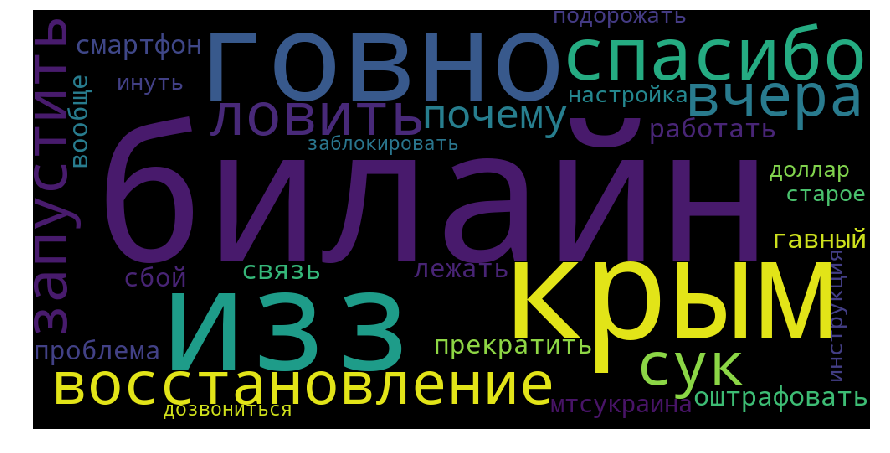

In [73]:
top = 30
features = tfidf.get_feature_names()
importances = clf_log.coef_
classes = clf_log.classes_
words_with_weights = sorted(list(zip(features, importances[0])),key=lambda x: abs(x[1]), reverse=True)
only_words = [word for word,_ in words_with_weights][:top]

cloud = WordCloud(width=1000, height=500).generate(' '.join(only_words))
plt.figure(figsize=(15, 15))
plt.imshow(cloud)
plt.axis('off')

+ И можем построить ещё для SGD

In [75]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

y_train = train_data['label'].values
y_test = test_data['label'].values

sgd_clf = linear_model.SGDClassifier(random_state=6345)
sgd_clf.fit(X_train, y_train)

y_pred = sgd_clf.predict(X_test)



(-0.5, 999.5, 499.5, -0.5)

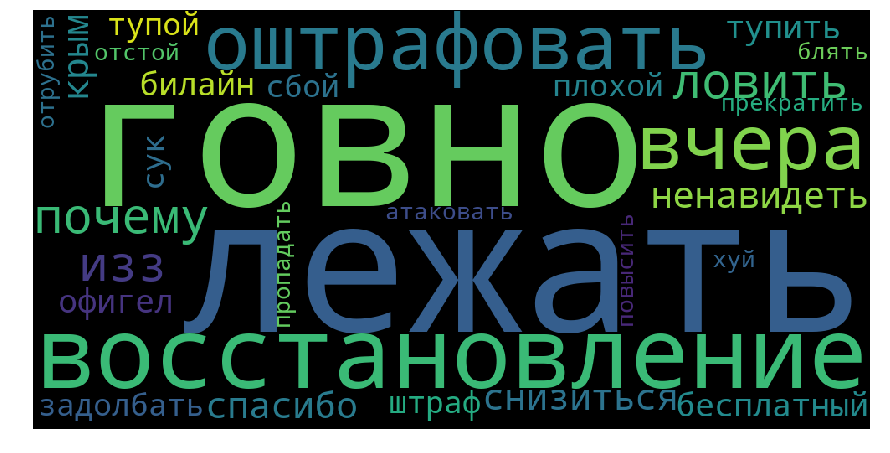

In [77]:
top = 30
features = tfidf.get_feature_names()
importances = sgd_clf.coef_
classes = sgd_clf.classes_
words_with_weights = sorted(list(zip(features, importances[0])),key=lambda x: abs(x[1]), reverse=True)
only_words = [word for word,_ in words_with_weights][:top]

cloud = WordCloud(width=1000, height=500).generate(' '.join(only_words))
plt.figure(figsize=(15, 15))
plt.imshow(cloud)
plt.axis('off')

+ А теперь определим лучшие параметры

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [49]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

y_train = train_data['label'].values
y_test = test_data['label'].values

In [68]:
params = [{'kernel':['poly'], 'C':[1.e-4, 2, 10, 100, 1000], 'degree':[2, 3, 5, 11]},
         {'kernel':['rbf'], 'C':[1.e-4, 2, 10, 100, 1000], 'gamma':['auto', 1.e-4, 1.e-2]},
         {'kernel':['linear'], 'C':[1.e-4, 2, 10, 100, 1000]}]

svc = SVC(class_weight='balanced')
grid = GridSearchCV(svc, params, cv=5, scoring='f1_weighted', )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

In [69]:
grid.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}